# Importation des librairies

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import glob
import librosa
from IPython.display import Audio
import soundfile as sf
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm


# Générétion des échantillons audio

In [49]:
def extract_segments_with_metadata():
    # Paths
    audio_folder = 'data/Respiratory_Sound_Database/audio_and_txt_files'
    annotation_folder = 'data/Respiratory_Sound_Database/audio_and_txt_files'

    diagnosis_df = pd.read_csv('data/Respiratory_Sound_Database/patient_diagnosis.csv', header=None, names=["Patient ID", "Diagnosis"])
    output_segments_folder = 'data/segments'

    # Initialisation des logs
    segments_metadata = []

    # Parcourir les fichiers audio et annotations
    for audio_file in os.listdir(audio_folder):
        if audio_file.endswith(".wav"):
            # Extraire l'ID du patient
            patient_id = int(audio_file.split('_')[0])
            location = audio_file.split('_')[2]  # Localisation (ex : Al, Tc)
            equipment = audio_file.split('_')[4].replace('.wav', '')  # Équipement (ex : AKGC417L)

            # Récupérer le diagnostic correspondant
            diagnosis_row = diagnosis_df.loc[diagnosis_df["Patient ID"] == patient_id, "Diagnosis"]
            if not diagnosis_row.empty:
                diagnosis = diagnosis_row.values[0]
            else:
                diagnosis = "Unknown"

            # Récupérer l'annotation correspondante
            annotation_file = audio_file.replace(".wav", ".txt")
            annotation_path = os.path.join(annotation_folder, annotation_file)
            if os.path.exists(annotation_path):
                # Charger l'audio
                audio_path = os.path.join(audio_folder, audio_file)
                try:
                    y, sr = librosa.load(audio_path, sr=None)
                except Exception as e:
                    print(f"Erreur lors du chargement de {audio_file}: {e}")
                    continue

                # Charger les annotations
                annotations = pd.read_csv(annotation_path, sep='\t', names=["Start", "End", "Crackles", "Wheezes"])

                # Extraire les segments
                for idx, row in annotations.iterrows():
                    start_sample = int(row["Start"] * sr)
                    end_sample = int(row["End"] * sr)
                    segment = y[start_sample:end_sample]

                    # Vérifier la validité du segment
                    if len(segment) == 0 or len(segment) < sr * 0.2:  # Ignorer les segments < 200ms
                        continue

                    # Sauvegarder le segment dans un fichier séparé
                    segment_filename = f"{patient_id}_{location}_{equipment}_segment_{idx+1}_{row['Start']:.2f}-{row['End']:.2f}.wav"
                    segment_path = os.path.join(output_segments_folder, segment_filename)
                    sf.write(segment_path, segment, sr)

                    # Ajouter les métadonnées dans la liste
                    segments_metadata.append({
                        "Patient_number": patient_id,
                        "File_Name": audio_file,
                        "Segment_File": segment_filename,
                        "Diagnosis": diagnosis,
                        "Location": location,
                        "Equipment": equipment,
                        "Start_(s)": row["Start"],
                        "End_(s)": row["End"],
                        "Crackles": row["Crackles"],
                        "Wheezes": row["Wheezes"],
                    })

    # Créer un DataFrame final avec les diagnostics
    metadata_df = pd.DataFrame(segments_metadata)
    metadata_df.to_csv("data/segments_metadata_with_diagnosis.csv", index=False)

    print(f"Segments extraits et sauvegardés dans : {output_segments_folder}")
    print("Métadonnées des segments sauvegardées dans : segments_metadata_with_diagnosis.csv")

# Exemple d'utilisation
extract_segments_with_metadata()

Segments extraits et sauvegardés dans : data/segments
Métadonnées des segments sauvegardées dans : segments_metadata_with_diagnosis.csv


# Chargement des données

In [61]:
path_audio = 'data/Respiratory_Sound_Database/audio_and_txt_files/'
path_segments = 'data/segments/'

def extract_demographic_data():

    path = 'data/demographic_info.txt'
    with open(path, 'r') as file:
        file = file.read()
    file = file.split('\n')[1:]
    file = [f.split(' ') for f in file]
    
    data = []
    for f in file :
        data.append({
            'Patient_number': f[0],
            'Age': f[1],
            'Sex': f[2]
        })
    return pd.DataFrame(data)

# Merge
df_segment = pd.read_csv('data/segments_metadata_with_diagnosis.csv', dtype={'Patient_number': str})
data = pd.merge(df_segment, extract_demographic_data(), on='Patient_number')

if not os.path.exists('data/data_generated'):
    os.makedirs('data/data_generated')
data.to_csv('data/data_generated/data_generated.csv', index=False)



# Filtre des données

In [51]:
# Filtre des données
df = pd.read_csv('data/data_generated/data_generated.csv')

# Drop les valeurs nulles
df = df.dropna()

# Target que l'on cible, on enlève les autres car trop peu fréquent
df = df[df['Diagnosis'].isin(['COPD', 'Healthy', 'URTI','Pneumonia'])]

# Conversion des colonnes en numeric
df['Start_(s)'] = pd.to_numeric(df['Start_(s)'])
df['End_(s)'] = pd.to_numeric(df['End_(s)'])
df['Crackles'] = pd.to_numeric(df['Crackles'])
df['Wheezes'] = pd.to_numeric(df['Wheezes'])
df['Age'] = pd.to_numeric(df['Age'])

In [52]:
# Change l'age en catégorie

def labelize_age(age):
    labels = {
        'bebe' : 3.,
        'enfant': 16. ,
        'adulte': 60,
        'vieux': 100
    }
    if labels['bebe'] >= age:
        return 'bebe'

    elif labels['enfant'] >= age:
        return 'enfant'

    elif labels['adulte'] >= age:
        return 'adulte'

    else:
        return 'vieux'

def add_age_label(df):
    df['Age'] = df['Age'].apply(lambda age : labelize_age(age))
    return df

df = add_age_label(df)

In [53]:
# Label encoder
labels_encoding = {
    'Diagnosis': LabelEncoder(),
    'Location': LabelEncoder(),
    'Equipment': LabelEncoder(),
    'Sex': LabelEncoder(),
    'Age': LabelEncoder()
}

for label, encoder in labels_encoding.items():
    df[label] = encoder.fit_transform(df[label])

df

,Patient_number,File_Name,Segment_File,Diagnosis,Location,Equipment,Start_(s),End_(s),Crackles,Wheezes,Age,Sex
0,101,101_1b1_Al_sc_Meditron.wav,101_Al_Meditron_segment_1_0.04-0.58.wav,3,0,3,0.036,0.579,0.0,0.0,1,0
1,101,101_1b1_Al_sc_Meditron.wav,101_Al_Meditron_segment_2_0.58-2.45.wav,3,0,3,0.579,2.450,0.0,0.0,1,0
2,101,101_1b1_Al_sc_Meditron.wav,101_Al_Meditron_segment_3_2.45-3.89.wav,3,0,3,2.450,3.893,0.0,0.0,1,0
3,101,101_1b1_Al_sc_Meditron.wav,101_Al_Meditron_segment_4_3.89-5.79.wav,3,0,3,3.893,5.793,0.0,0.0,1,0
4,101,101_1b1_Al_sc_Meditron.wav,101_Al_Meditron_segment_5_5.79-7.52.wav,3,0,3,5.793,7.521,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6893,226,226_1b1_Pl_sc_LittC2SE.wav,226_Pl_LittC2SE_segment_7_11.72-13.69.wav,2,4,2,11.721,13.693,1.0,0.0,2,1
6894,226,226_1b1_Pl_sc_LittC2SE.wav,226_Pl_LittC2SE_segment_8_13.69-15.54.wav,2,4,2,13.693,15.536,0.0,0.0,2,1
6895,226,226_1b1_Pl_sc_LittC2SE.wav,226_Pl_LittC2SE_segment_9_15.54-17.49.wav,2,4,2,15.536,17.493,0.0,0.0,2,1
6896,226,226_1b1_Pl_sc_LittC2SE.wav,226_Pl_LittC2SE_segment_10_17.49-19.44.wav,2,4,2,17.493,19.436,1.0,0.0,2,1


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6535 entries, 0 to 6897
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patient_number  6535 non-null   int64  
 1   File_Name       6535 non-null   object 
 2   Segment_File    6535 non-null   object 
 3   Diagnosis       6535 non-null   int64  
 4   Location        6535 non-null   int64  
 5   Equipment       6535 non-null   int64  
 6   Start_(s)       6535 non-null   float64
 7   End_(s)         6535 non-null   float64
 8   Crackles        6535 non-null   float64
 9   Wheezes         6535 non-null   float64
 10  Age             6535 non-null   int64  
 11  Sex             6535 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 663.7+ KB


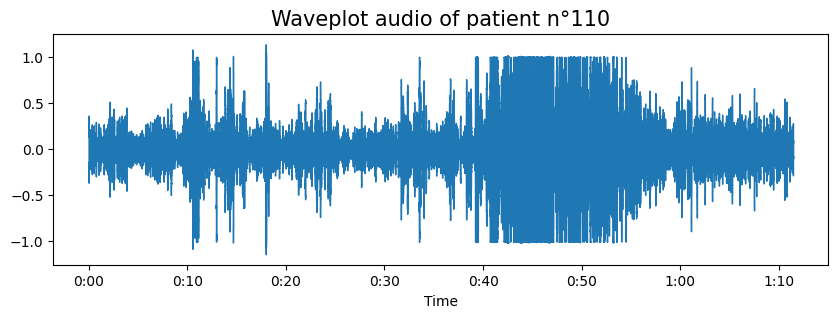

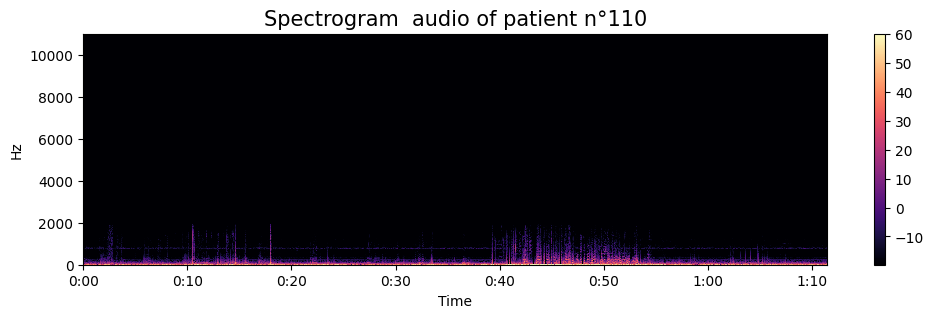

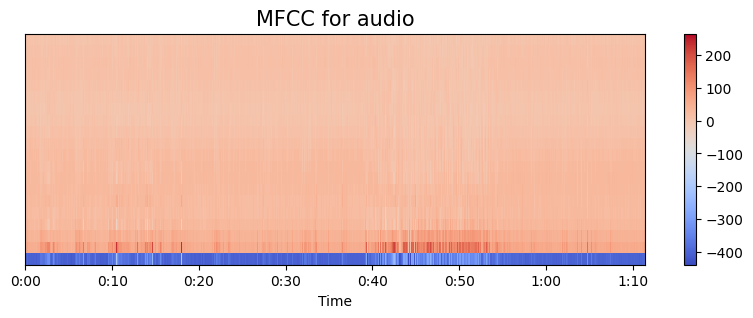

In [66]:

def create_waveplot(data, sr, id):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot audio of patient n°{}'.format(id), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, id):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram  audio of patient n°{}'.format(id), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

def show_mfcc(data, sr):
    mfccs = librosa.feature.mfcc(y=data, sr=sr)
    plt.figure(figsize=(10, 3))
    plt.title('MFCC for audio', size=15)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.show()

def show_audio(id=101):
    paths = path_audio + df['File_Name'][df['Patient_number']==id]
    if paths.empty:
        print("No audio file found")
        return None
    path = paths.values[0]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, id)
    create_spectrogram(data, sampling_rate, id)
    show_mfcc(data, sampling_rate)
    return path

path_test = show_audio(110)

Audio(path_test) if path_test else None
    

# Data augmentation

In [28]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)



# Extraction des features

In [75]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    
    return result

def get_features(path):
    data, sample_rate = librosa.load(path)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))
    
    return result

In [ ]:
# downsample
df = pd.concat([df[df['Diagnosis'] == 0].sample(243), df[df['Diagnosis'] == 1].sample(243), df[df['Diagnosis'] == 2].sample(243), df[df['Diagnosis'] == 3].sample(243)])

df['Diagnosis'].value_counts()


Diagnosis
0    243
1    243
2    243
3    243
Name: count, dtype: int64


Diagnosis
0    243
1    243
2    243
3    243
Name: count, dtype: int64

In [77]:
X, Y = [], []
for i in tqdm(range(len(df))):
    segment_file = df['Segment_File'].iloc[i]
    segment_path = os.path.join(path_segments, segment_file)
    
    if os.path.exists(segment_path):
        features = get_features(segment_path)

        for ele in features:
            ele = np.append(ele, df[['Location','Equipment','Crackles', 'Wheezes','Sex']].iloc[i])
            X.append(ele)
            Y.append(df['Diagnosis'].iloc[i])
    else:
        print(f"File {segment_file} does not exist")

X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape)

  2%|▏         | 21/972 [00:00<00:43, 21.98it/s]c:\Users\bluek\anaconda3\envs\son\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
  3%|▎         | 33/972 [00:01<00:45, 20.63it/s]c:\Users\bluek\anaconda3\envs\son\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
  8%|▊         | 82/972 [00:03<00:40, 22.22it/s]c:\Users\bluek\anaconda3\envs\son\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 10%|▉         | 97/972 [00:04<00:39, 22.14it/s]c:\Users\bluek\anaconda3\envs\son\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 11%|█         | 106/972 [00:04<00:43, 19.94it/s]c:\Users\bluek\anaconda3\envs\son\Lib\site-packages\librosa\core\pitch.py:101: UserWarning:

(1944, 167) (1944,)


In [78]:
Features = pd.DataFrame(X)
Features['Diagnosis'] = Y
Features.to_csv('./data/features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,Diagnosis
0,0.005615,0.833731,0.824605,0.789201,0.771579,0.797447,0.848670,0.817705,0.768267,0.720173,...,6.172706e-08,5.853172e-08,3.358113e-08,7.567563e-09,5.0,2.0,0.0,0.0,1.0,0
1,0.006999,0.842750,0.832756,0.797530,0.779904,0.810042,0.857514,0.815485,0.767760,0.725555,...,2.075748e-07,2.102822e-07,1.698390e-07,1.434896e-07,5.0,2.0,0.0,0.0,1.0,0
2,0.006496,0.844980,0.813808,0.796976,0.791567,0.772448,0.759172,0.737691,0.777703,0.828301,...,1.311815e-05,1.197427e-05,6.189177e-06,5.929160e-07,6.0,0.0,0.0,0.0,1.0,0
3,0.125230,0.908069,0.918018,0.929650,0.949590,0.924584,0.805231,0.811096,0.831329,0.860848,...,5.164065e-02,5.138501e-02,4.922342e-02,5.102245e-02,6.0,0.0,0.0,0.0,1.0,0
4,0.007661,0.801468,0.801956,0.815615,0.818539,0.839595,0.828903,0.808560,0.847815,0.877043,...,2.322690e-05,2.182143e-05,1.253796e-05,1.087224e-06,1.0,0.0,0.0,0.0,1.0,0


# Création du modele

In [79]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


def load_data_for_training():
    """
    Loads and preprocesses data for training a machine learning model.
    """
    
    Features = pd.read_csv('./data/features.csv')

    Features = Features.dropna()

    X = Features.iloc[:, :-1]
    Y = Features['Diagnosis']

    encoder = OneHotEncoder()
    Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
    print(f"Shape of X before encoding: {X.shape}")
    print(f"Shape of Y after encoding: {Y.shape}")


    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    x_train =np.expand_dims(x_train, axis=2)
    x_test= np.expand_dims(x_test, axis=2)
    return x_train, x_test, y_train, y_test




Shape of X before encoding: (1944, 167)
Shape of Y after encoding: (1944, 4)
Accuracy of Random Forest Classifier: 93.57%


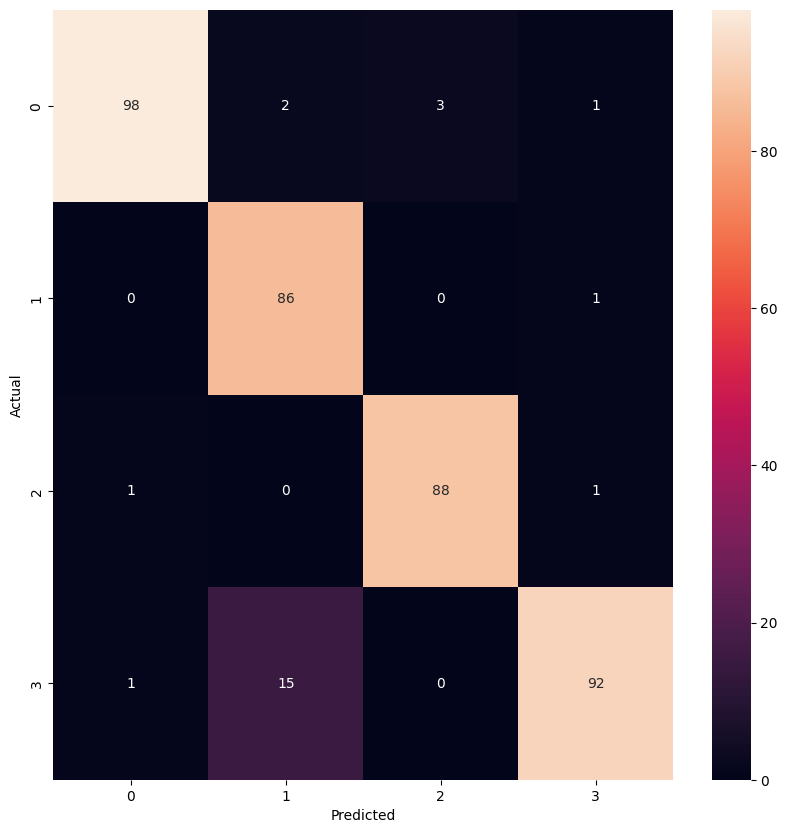

In [84]:
x_train, x_test, y_train, y_test = load_data_for_training()

# Reshape x_train and x_test to 2D arrays
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

# Convert one-hot encoded labels back to single integer labels
y_train_single = np.argmax(y_train, axis=1)
y_test_single = np.argmax(y_test, axis=1)

model = RandomForestClassifier(n_estimators=100, max_depth=50)
model.fit(x_train_reshaped, y_train_single)
y_pred = model.predict(x_test_reshaped)
accuracy = accuracy_score(y_test_single, y_pred)
print("Accuracy of Random Forest Classifier: {:.2f}%".format(accuracy*100))

# affiche la matrice de confusion
cm = confusion_matrix(y_test_single, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=df['Diagnosis'].unique(), yticklabels=df['Diagnosis'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Text(95.72222222222221, 0.5, 'Actual')

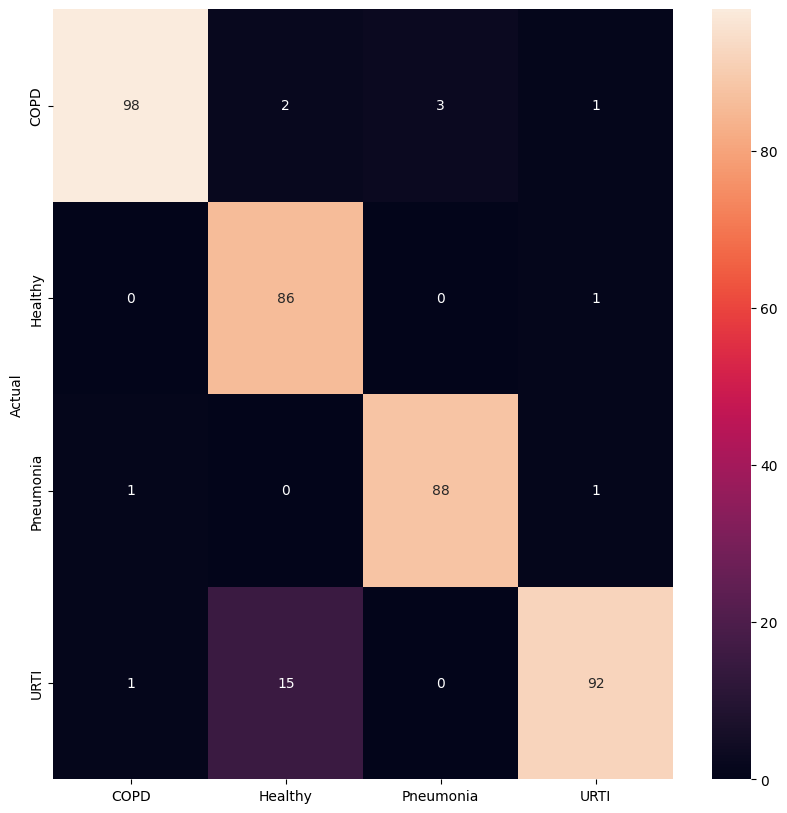

In [88]:
# affiche la matrice de confusion avec le label encoder
cm = confusion_matrix(y_test_single, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_encoding['Diagnosis'].inverse_transform([0, 1, 2,3]), yticklabels=labels_encoding['Diagnosis'].inverse_transform([0, 1, 2,3]))
plt.ylabel('Actual')

In [81]:
# Affiche label pour diagnosis
labels_encoding['Diagnosis'].inverse_transform([0, 1, 2,3])

array(['COPD', 'Healthy', 'Pneumonia', 'URTI'], dtype=object)

In [82]:
# Report 
print(classification_report(y_test_single, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.91      0.95       104
           1       0.81      0.95      0.88        87
           2       0.94      0.97      0.95        90
           3       0.94      0.84      0.89       108

    accuracy                           0.92       389
   macro avg       0.92      0.92      0.92       389
weighted avg       0.92      0.92      0.92       389

